In [50]:
import tensorflow as tf
from keras import backend as K

In [51]:
import os
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

In [52]:
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

In [53]:
test_data_dir = f'test'

In [77]:
testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=42)

Found 5534 images belonging to 6 classes.


In [55]:
modelpath = 'checkpoint_file.h5'

In [56]:
import tensorflow as tf

In [57]:
import keras
w, h = (224, 224)
base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(w, h, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [58]:
#Freeze the base model
base_model.trainable = False

In [59]:
inputs = keras.Input(shape=(w, h, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
outputs = keras.layers.Dense(6, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [60]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()])

In [61]:
model.load_weights(modelpath)

In [62]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 1024)              25691136  
                                                                 
 dense_9 (Dense)             (None, 6)                 6150      
                                                                 
Total params: 40,411,974
Trainable params: 25,697,286
Non-trainable params: 14,714,688
_________________________________________________________________


In [63]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [66]:
type(model)

keras.engine.functional.Functional

In [67]:
model.predict_generator(testgen)

/var/folders/br/p4vyyhqs7kg9vnb50rbzwr4r0000gp/T/ipykernel_98234/1445123030.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  model.predict_generator(testgen)


array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [2.2469240e-16, 0.0000000e+00, 1.8916037e-29, 0.0000000e+00,
        5.0557930e-19, 1.0000000e+00],
       [1.7492845e-17, 0.0000000e+00, 1.3091324e-35, 0.0000000e+00,
        1.5043586e-31, 1.0000000e+00],
       [6.9941950e-21, 0.0000000e+00, 3.3409182e-37, 0.0000000e+00,
        4.3797092e-37, 1.0000000e+00]], dtype=float32)

In [78]:
from sklearn.metrics import classification_report, confusion_matrix

num_of_test_samples = 5534
batch_size = 32
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(testgen, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = ['Apple', 'Banana', 'Guava', 'Lime', 'Orange', 'Pomegranate']
print(classification_report(testgen.classes, y_pred, target_names=target_names))

/var/folders/br/p4vyyhqs7kg9vnb50rbzwr4r0000gp/T/ipykernel_98234/3469715369.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(testgen, num_of_test_samples // batch_size+1)


Confusion Matrix
[[ 673    1    0    0    3   10]
 [   1  659    0    0    0    0]
 [  39    1  608    5    0   31]
 [  73    3   14  538   11   14]
 [  68    8   24   36  553   23]
 [  57    0   16    5   27 2033]]
Classification Report
              precision    recall  f1-score   support

       Apple       0.74      0.98      0.84       687
      Banana       0.98      1.00      0.99       660
       Guava       0.92      0.89      0.90       684
        Lime       0.92      0.82      0.87       653
      Orange       0.93      0.78      0.85       712
 Pomegranate       0.96      0.95      0.96      2138

    accuracy                           0.92      5534
   macro avg       0.91      0.90      0.90      5534
weighted avg       0.92      0.92      0.92      5534



<AxesSubplot:>

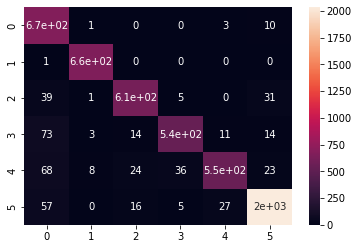

In [81]:
import seaborn as sns
cf_matrix = confusion_matrix(testgen.classes, y_pred)
sns.heatmap(confusion_matrix(testgen.classes, y_pred), annot=True)

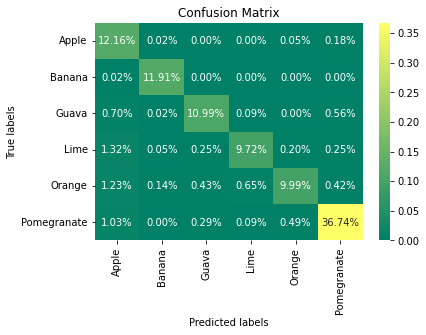

In [106]:
import matplotlib.pyplot as plt     

ax= plt.subplot()

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='summer', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(target_names, rotation=90); ax.yaxis.set_ticklabels(target_names, rotation=0);

In [101]:
from pretty_confusion_matrix import pp_matrix